In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import anndata
import scanpy.external as sce
import seaborn as sns
import matplotlib as mpl
import seaborn as sns
import scipy.stats as st
from scipy import stats
from scipy.stats import norm
from matplotlib.pyplot import rc_context
import scvelo as scv


In [2]:
#data processed/demultiplex/classify hashtag or doublet by hashsolo
exp97=sc.read('exp97_solo.h5',gex_only=False)
exp97=exp97[(exp97.obs['Classification']=='HTO3')|(exp97.obs['Classification']=='HTO4'),:]


In [3]:
exp97.layers["counts"] = exp97.X.copy()

In [4]:
exp97.var["feature_types"].value_counts()


Gene Expression     36691
Antibody Capture        7
Name: feature_types, dtype: int64

In [5]:
sc.pp.filter_cells(exp97, min_genes=500)
sc.pp.filter_genes(exp97, min_cells=3)
exp97.var['mt'] = exp97.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(exp97, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

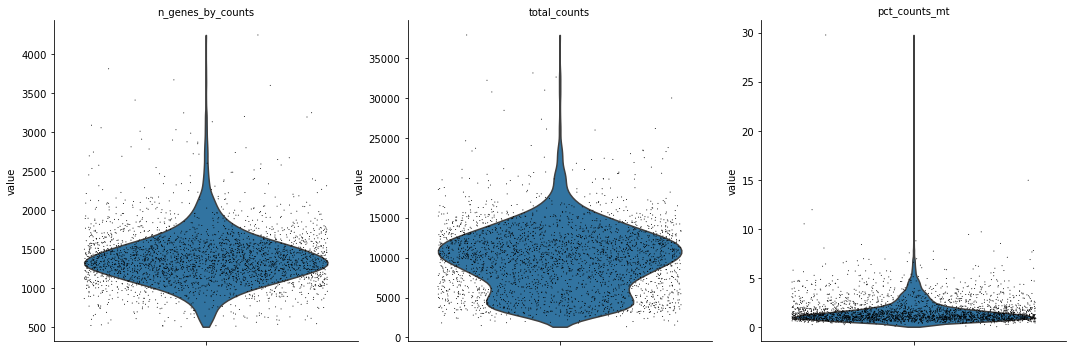

In [6]:
sc.pl.violin(exp97, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

<Figure size 288x288 with 0 Axes>

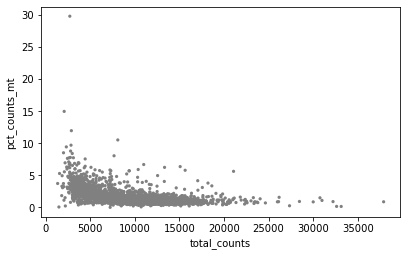

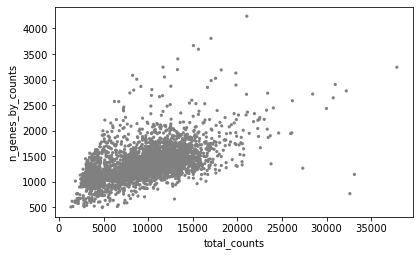

In [7]:
plt.figure(figsize=(4,4))
sc.pl.scatter(exp97, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(exp97, x='total_counts', y='n_genes_by_counts')

In [8]:
exp97 = exp97[exp97.obs.total_counts < 30000, :]
exp97 = exp97[exp97.obs.pct_counts_mt < 10, :]

In [9]:
AB=exp97[(exp97.obs_vector('IgM_ADT')>200)&(exp97.obs_vector('CD38_ADT')<200),:]
PBC=exp97[~((exp97.obs_vector('IgM_ADT')>200)&(exp97.obs_vector('CD38_ADT')<200)),:]
prePB=PBC[(PBC.obs_vector('CD38_ADT')<60),:]
PB=PBC[(PBC.obs_vector('CD38_ADT')>=60)&(PBC.obs_vector('CD138_ADT')<100),:]
PC=PBC[(PBC.obs_vector('CD38_ADT')>=60)&(PBC.obs_vector('CD138_ADT')>=100),:]

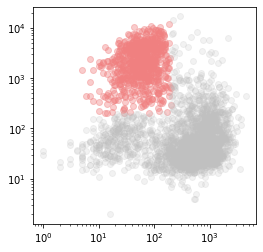

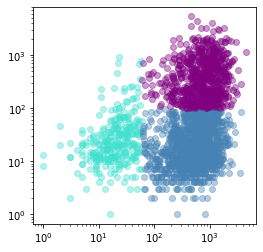

In [10]:
plt.figure(figsize=(4,4))
plt.scatter(AB.obs_vector('CD38_ADT'),AB.obs_vector('IgM_ADT') , alpha=0.4 ,color='lightcoral')
plt.scatter(PBC.obs_vector('CD38_ADT'),PBC.obs_vector('IgM_ADT') , alpha=0.2,color='silver' )

plt.xscale('log')
plt.yscale('log')

plt.figure(figsize=(4,4))
plt.scatter(prePB.obs_vector('CD38_ADT'),prePB.obs_vector('CD138_ADT') , alpha=0.4,color='turquoise' )
plt.scatter(PB.obs_vector('CD38_ADT'),PB.obs_vector('CD138_ADT') , alpha=0.4,color='steelblue' )
plt.scatter(PC.obs_vector('CD38_ADT'),PC.obs_vector('CD138_ADT') , alpha=0.4,color='purple' )

plt.xscale('log')
plt.yscale('log')

In [11]:
exp97.obs['phenotype'] = 'BCR+CD38lo'


In [12]:
prePBi=prePB.obs.index
PBi=PB.obs.index
PCi=PC.obs.index
exp97.obs.loc[prePBi, 'phenotype'] = 'BCR-CD38lo'
exp97.obs.loc[PBi, 'phenotype'] = 'CD38hiCD138lo'
exp97.obs.loc[PCi, 'phenotype'] = 'CD38hiCD138hi'

In [13]:
exp97.obs['phenotype_'] = 'B cells'
PBi=PB.obs.index
PCi=PC.obs.index
exp97.obs.loc[PBi, 'phenotype_'] = 'CD38hi'
exp97.obs.loc[PCi, 'phenotype_'] = 'CD38hi'

In [14]:
hto=exp97[:,exp97.var_names.str.startswith('HTO')].copy()
# # protein = exp97[:, ((exp97.var["feature_types"] == "Antibody Capture"))].copy()
protein = exp97[:, ((exp97.var["feature_types"] == "Antibody Capture")& ~(exp97.var_names.str.startswith('HTO')))].copy()
rna = exp97[:, exp97.var["feature_types"] == "Gene Expression"].copy()
# rnap = exp97[:, ~(exp97.var_names.str.startswith('HTO'))].copy()

In [15]:
hto.layers["counts"] = hto.X.copy()
protein.layers["counts"] = protein.X.copy()


In [16]:
sc.pp.normalize_total(hto)
sc.pp.log1p(hto)
sc.pp.pca(hto, n_comps=1)


In [48]:
sc.pp.neighbors(hto, n_neighbors=20)  # why can't we just work with the default neighbors?
sc.tl.leiden(hto,resolution = 0.05, key_added="hto_leiden")

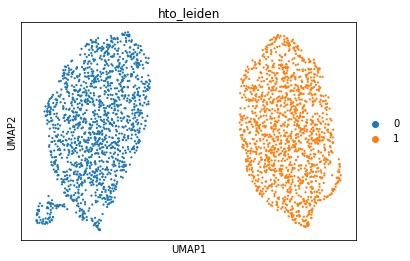

In [49]:
hto.obsp["hto_connectivities"] = hto.obsp["connectivities"].copy()
sc.tl.umap(hto)
sc.pl.umap(hto, color="hto_leiden", size=20)

In [17]:
sc.pp.normalize_total(protein)
sc.pp.log1p(protein)
sc.pp.pca(protein, n_comps=2)


In [18]:
sc.pp.neighbors(protein, n_neighbors=20)  # why can't we just work with the default neighbors?
sc.tl.leiden(protein,resolution = 0.2, key_added="protein_leiden")

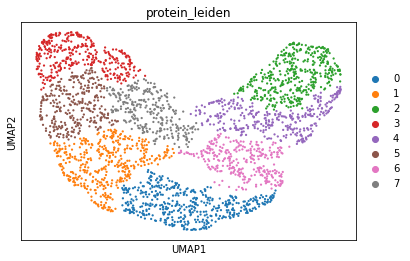

In [19]:
protein.obsp["protein_connectivities"] = protein.obsp["connectivities"].copy()
sc.tl.umap(protein)
sc.pl.umap(protein, color="protein_leiden", size=20)

In [20]:
rna = exp97[:, exp97.var["feature_types"] == "Gene Expression"].copy()


In [21]:
rna.layers["counts"] = rna.X.copy()


In [22]:
sc.pp.normalize_total(rna)
sc.pp.log1p(rna)

In [23]:
sc.pp.pca(rna)
sc.pp.neighbors(rna, n_neighbors=20)   # why can't we just work with the default neighbors?
sc.tl.umap(rna)
sc.tl.leiden(rna,resolution = 0.4, key_added="rna_leiden")

In [24]:
rna.obsm["protein"] = protein.to_df()
rna.obsm["protein_umap"] = protein.obsm["X_umap"]
rna.obs["protein_leiden"] = protein.obs["protein_leiden"]
rna.obsp["rna_connectivities"] = rna.obsp["connectivities"].copy()
rna.obsp["protein_connectivities"] = protein.obsp["protein_connectivities"]

In [25]:
sc.tl.umap(rna)


In [26]:
rna

AnnData object with n_obs × n_vars = 2897 × 14802
    obs: 'most_likely_hypothesis', 'Classification', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'phenotype', 'phenotype_', 'rna_leiden', 'protein_leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'leiden'
    obsm: 'X_pca', 'X_umap', 'protein', 'protein_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities', 'rna_connectivities', 'protein_connectivities'

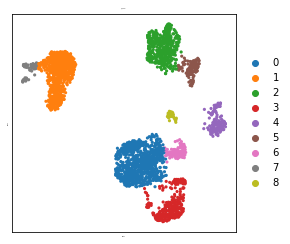

In [27]:
with rc_context({'figure.figsize': (4, 4),'axes.labelsize': False,'axes.titlesize':False}):
#     sc.pl.umap(rna, color=["rna_leiden"], size=40)    
    ax = sc.pl.umap(rna, color=["rna_leiden"], size=40)


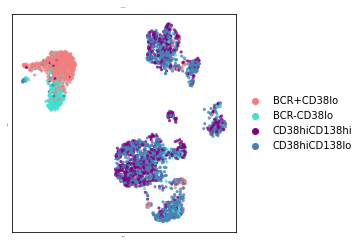

In [28]:
with rc_context({'figure.figsize': (4, 4),'axes.labelsize': False,'axes.titlesize':False}):
#     sc.pl.umap(rna, color=["rna_leiden"], size=40)    
    ax = sc.pl.umap(rna, color=["phenotype"], size=40,palette={
        "BCR+CD38lo": "lightcoral",
        "BCR-CD38lo": "turquoise",
        "CD38hiCD138lo": "steelblue",
        "CD38hiCD138hi": "purple",
    }, alpha=0.8)
# plt.savefig('pheno_umap.pdf')
#     sc.pl.embedding(rna, basis="protein_umap", color=["rna_leiden", "protein_leiden"], size=10)

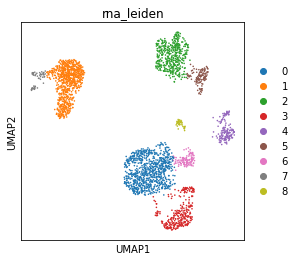

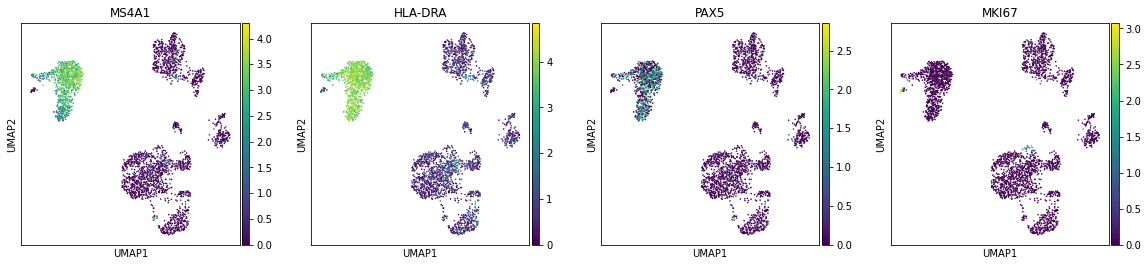

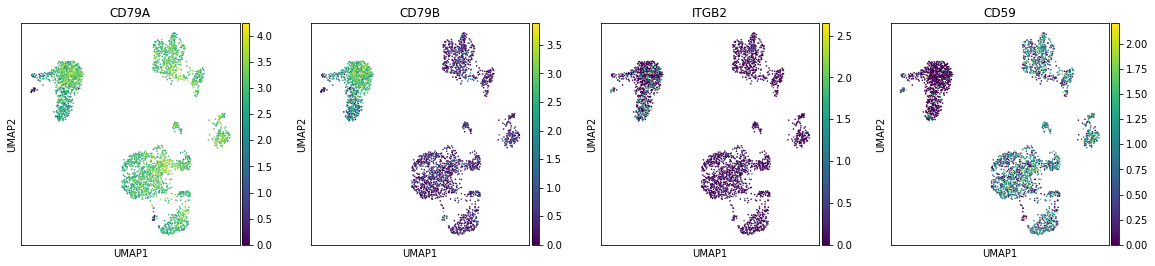

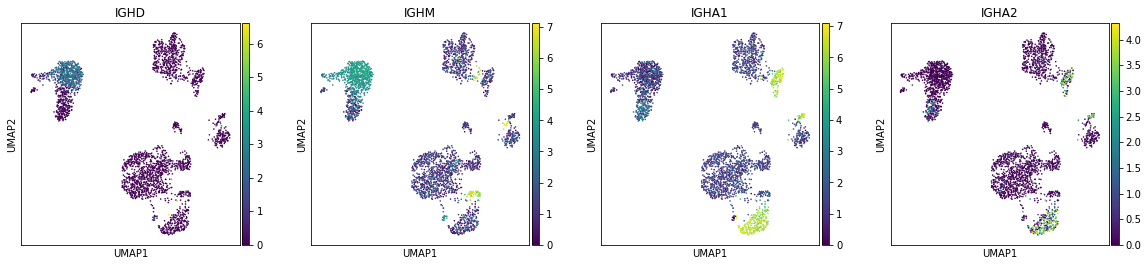

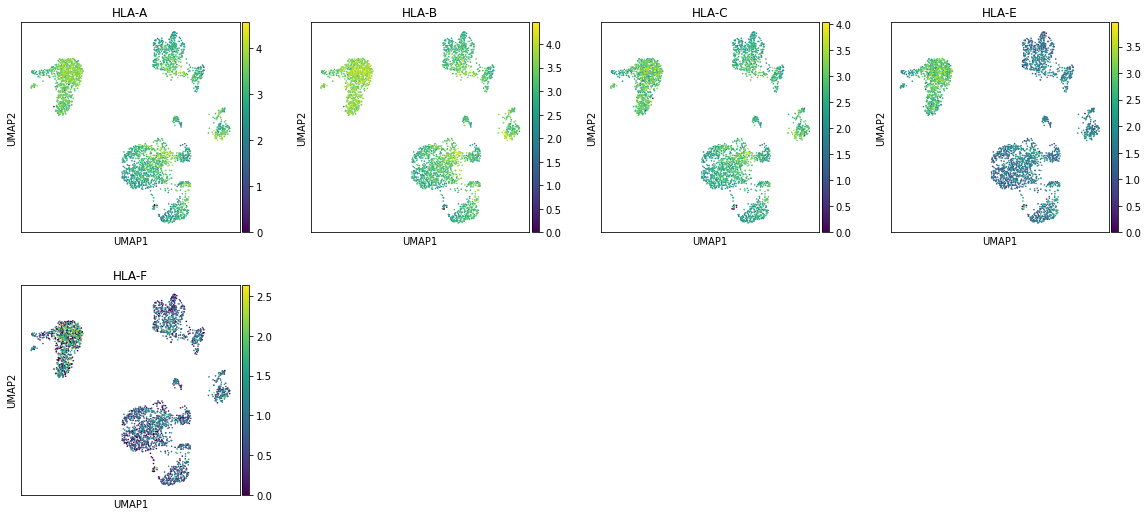

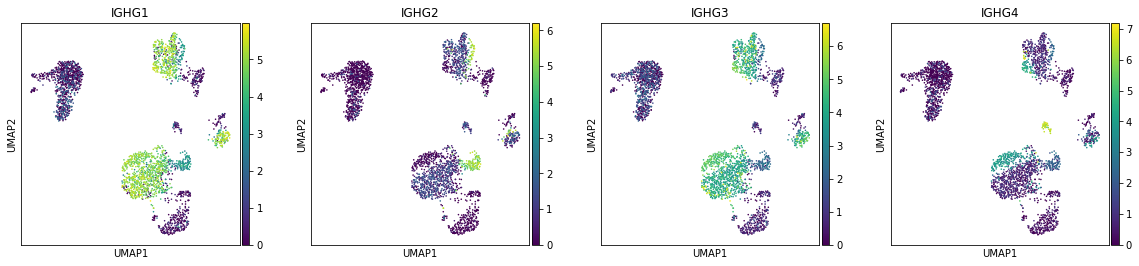

In [65]:
with rc_context({'figure.figsize': (4, 4)}):

    sc.pl.umap(rna, color=['rna_leiden'], size=10)
    sc.pl.umap(rna, color=["MS4A1",'HLA-DRA','PAX5','MKI67'], size=10)
    sc.pl.umap(rna, color=['CD79A','CD79B','ITGB2','CD59'], size=10)

    sc.pl.umap(rna, color=["IGHD",'IGHM','IGHA1','IGHA2'], size=10)
    sc.pl.umap(rna, color=["HLA-A",'HLA-B','HLA-C','HLA-E','HLA-F'], size=10)

    sc.pl.umap(rna, color=["IGHG1",'IGHG2','IGHG3','IGHG4'], size=10)
#     sc.pl.umap(rna, color=['IGKC',"IGLC1",'IGLC2','IGLC3'], size=10)
#     sc.pl.umap(rna, color=["JCHAIN",'PRDM1','XBP1','IRF4'], size=10)
#     sc.pl.umap(rna, color=["CD48",'SLAMF7','ITGB1','ITGA6'], size=10)
#     sc.pl.umap(rna, color=['TNFRSF13B','IGHG1','IGHA1','IGHA2'], size=10)

#     sc.pl.umap(rna, color=['MCL1','BCL2','BCL2L1'], size=10)
#     sc.pl.umap(rna, color=['CD59','TMBIM6','ITGA6','ZFP36L1'], size=20)


In [29]:
rna.obs['phenotype'].cat.reorder_categories(['BCR+CD38lo','BCR-CD38lo','CD38hiCD138lo','CD38hiCD138hi'], inplace=True)


In [30]:
pbpc = rna[rna.obs.phenotype.isin(['CD38hiCD138lo','CD38hiCD138hi'])].copy()
sc.tl.rank_genes_groups(pbpc, 'phenotype', method='t-test')



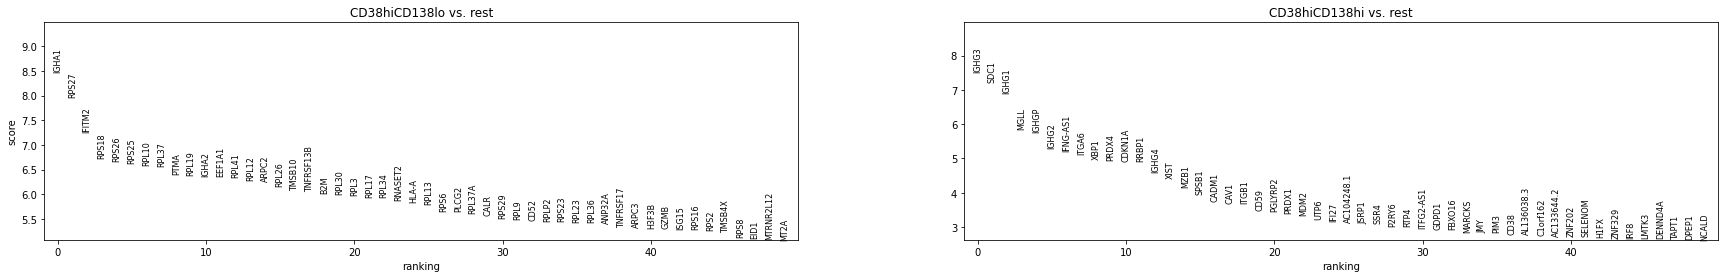

In [31]:
with rc_context({'figure.figsize': (15, 4)}):

    sc.pl.rank_genes_groups(pbpc, n_genes=50, sharey=False)

In [137]:
df=pd.DataFrame(columns=['CD38hiCD138lo','CD38hiCD138hi'])
for i in range(0,100):
    df. loc[i]=list(pbpc.uns['rank_genes_groups']['names'][i])
df.to_csv('pbpc.csv')

In [200]:
df1=pd.DataFrame(columns=['BCR+CD38lo','BCR-CD38lo','CD38hiCD138lo','CD38hiCD138hi'])
for i in range(0,100):
    df1. loc[i]=list(rna.uns['rank_genes_groups']['names'][i])
df1.to_csv('pheno.csv')

In [104]:
sc.tl.rank_genes_groups(rna, 'rna_leiden', method='t-test')
sc.tl.dendrogram(rna,groupby='rna_leiden')

In [172]:
df2=pd.DataFrame(columns=sorted(set(rna.obs['rna_leiden'])))
for i in range(0,100):
    df2. loc[i]=list(rna.uns['rank_genes_groups']['names'][i])
df2.to_csv('rna_cluster.csv')

In [481]:
pbpc=pd.read_csv('d13_pbpc.csv')